### Texture Analysis Section ###

Corresponding to section 2.5 of the report, primarily applying texture analysis to a sheet of paper and a wooden chopping board found in my flat.

(No pieces of paper or wooden chopping boards were harmed in the making of this project!)

In [ ]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import gaussian, sobel
from skimage.segmentation import active_contour
from skimage import io, color, img_as_ubyte
from tqdm import tqdm
from scipy.stats import skew
from skimage.feature import graycomatrix, graycoprops
from skimage.util import img_as_uint
from matplotlib.gridspec import GridSpec


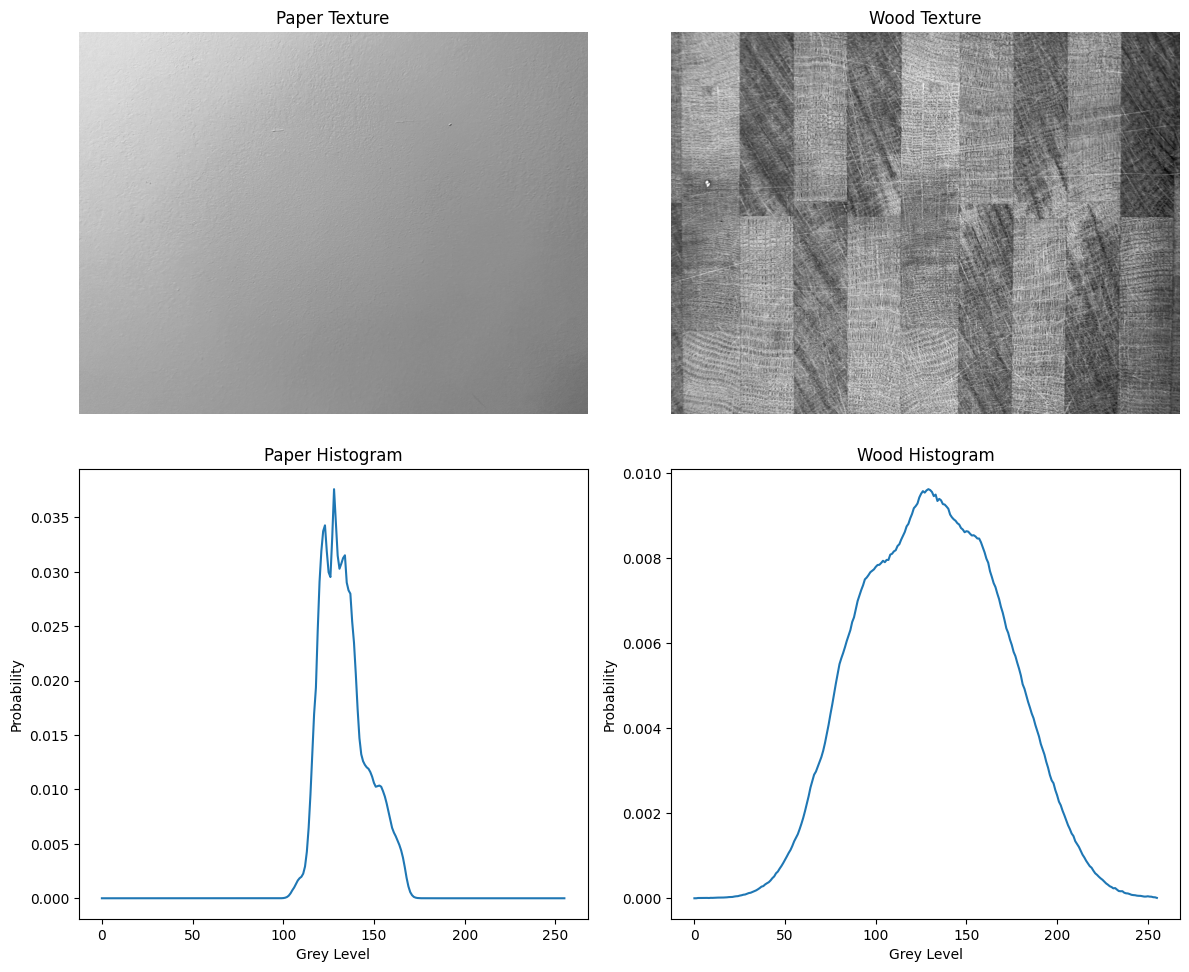

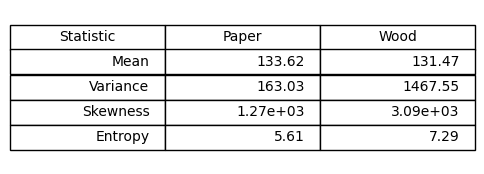

In [ ]:
# create some helper functions

def load_grayscale_image(path):
    """
    load image, convert to grayscale, return uint8 image.
    """
    img = io.imread(path)
    if img.ndim == 3:
        img = color.rgb2gray(img)
    return img_as_ubyte(img)


def histogram_statistics(img, num_levels=256):
    """
    compute histogram-based texture statistics:
    mean, variance, skewness, entropy.
    """
    # Histogram
    hist, bin_edges = np.histogram(
        img.flatten(),
        bins=num_levels,
        range=(0, num_levels),
        density=True  # normalised histogram
    )

    z = np.arange(num_levels)

    # mean
    mean = np.sum(z * hist)

    # variance
    variance = np.sum((z - mean) ** 2 * hist)

    # skewness (histogram-based definition)
    skewness = np.sum((z - mean) ** 3 * hist)

    # entropy (avoid log(0))
    hist_nonzero = hist[hist > 0]
    entropy = -np.sum(hist_nonzero * np.log2(hist_nonzero))

    return mean, variance, skewness, entropy, hist

# load images
paper_img = load_grayscale_image("IMG_6623.jpeg")
wood_img = load_grayscale_image("IMG_6622.jpeg")

# compute statistics
paper_stats = histogram_statistics(paper_img)
wood_stats = histogram_statistics(wood_img)

# unpack
(p_mean, p_var, p_skew, p_entropy, p_hist) = paper_stats
(w_mean, w_var, w_skew, w_entropy, w_hist) = wood_stats

# plot for comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# top-left: paper image
axes[0, 0].imshow(paper_img, cmap="gray")
axes[0, 0].set_title("Paper Texture")
axes[0, 0].axis("off")

# top-right: wood image
axes[0, 1].imshow(wood_img, cmap="gray")
axes[0, 1].set_title("Wood Texture")
axes[0, 1].axis("off")

# bottom-left: paper histogram
axes[1, 0].plot(p_hist)
axes[1, 0].set_title("Paper Histogram")
axes[1, 0].set_xlabel("Grey Level")
axes[1, 0].set_ylabel("Probability")

# bottom-right: wood histogram
axes[1, 1].plot(w_hist)
axes[1, 1].set_title("Wood Histogram")
axes[1, 1].set_xlabel("Grey Level")
axes[1, 1].set_ylabel("Probability")

plt.tight_layout()
plt.show()

# summary statistics table
stats_table = [
    ["Mean", f"{p_mean:.2f}", f"{w_mean:.2f}"],
    ["Variance", f"{p_var:.2f}", f"{w_var:.2f}"],
    ["Skewness", f"{p_skew:.2e}", f"{w_skew:.2e}"],
    ["Entropy", f"{p_entropy:.2f}", f"{w_entropy:.2f}"],
]

fig, ax = plt.subplots(figsize=(6, 2))
ax.axis("off")

table = ax.table(
    cellText=stats_table,
    colLabels=["Statistic", "Paper", "Wood"],
    loc="center"
)

table.scale(1, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(10)

plt.show()


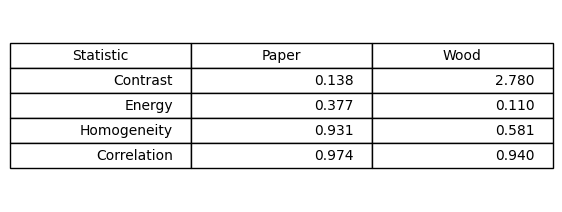

In [ ]:
def quantize_image(img, levels=32):
    """
    reduce number of grey levels for stable GLCM computation.
    """
    img_q = (img / (256 / levels)).astype(np.uint8)
    return img_q


def glcm_features(img, levels=32, distance=1):
    """
    compute averaged Haralick features from GLCM.
    """
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    glcm = graycomatrix(
        img,
        distances=[distance],
        angles=angles,
        levels=levels,
        symmetric=True,
        normed=True
    )

    features = {
        "Contrast": np.mean(graycoprops(glcm, "contrast")),
        "Energy": np.mean(graycoprops(glcm, "energy")),
        "Homogeneity": np.mean(graycoprops(glcm, "homogeneity")),
        "Correlation": np.mean(graycoprops(glcm, "correlation"))
    }

    return features, glcm

# load and process images
paper = load_grayscale_image("IMG_6623.jpeg")
wood = load_grayscale_image("IMG_6622.jpeg")

paper_q = quantize_image(paper)
wood_q = quantize_image(wood)

paper_feats, paper_glcm = glcm_features(paper_q)
wood_feats, wood_glcm = glcm_features(wood_q)

# stats table
stats = [
    ["Contrast", paper_feats["Contrast"], wood_feats["Contrast"]],
    ["Energy", paper_feats["Energy"], wood_feats["Energy"]],
    ["Homogeneity", paper_feats["Homogeneity"], wood_feats["Homogeneity"]],
    ["Correlation", paper_feats["Correlation"], wood_feats["Correlation"]],
]

fig, ax = plt.subplots(figsize=(7, 2.5))
ax.axis("off")

table = ax.table(
    cellText=[[s[0], f"{s[1]:.3f}", f"{s[2]:.3f}"] for s in stats],
    colLabels=["Statistic", "Paper", "Wood"],
    loc="center"
)

table.scale(1, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(10)

plt.show()

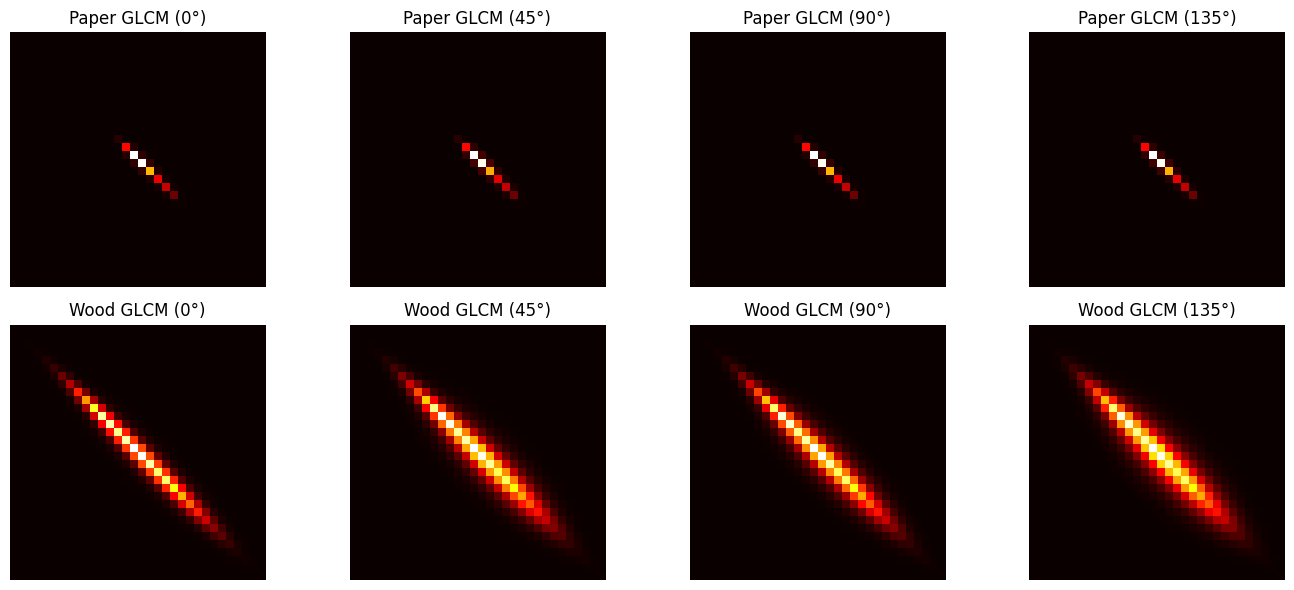

In [ ]:
def plot_glcm_comparison(paper_glcm, wood_glcm):
    angles = ["0°", "45°", "90°", "135°"]
    titles = ["Paper GLCM", "Wood GLCM"]

    fig, axes = plt.subplots(2, 4, figsize=(14, 6))

    # first row: Paper
    for i in range(4):
        axes[0, i].imshow(paper_glcm[:, :, 0, i], cmap="hot")
        axes[0, i].set_title(f"{titles[0]} ({angles[i]})")
        axes[0, i].axis("off")

    # second row: Wood
    for i in range(4):
        axes[1, i].imshow(wood_glcm[:, :, 0, i], cmap="hot")
        axes[1, i].set_title(f"{titles[1]} ({angles[i]})")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()

plot_glcm_comparison(paper_glcm, wood_glcm)